In [1]:
from bs4 import BeautifulSoup
import re
import os
from tqdm import tqdm
from collections import Counter
import torch
import time
import gensim
import pymorphy2
import numpy as np

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [3]:
proj_types, proj_names, proj_descrs = [],[],[]
folders = os.listdir('texts')
for folder in tqdm(folders):
    f = open(f"texts/{folder}/choose", "r", encoding="utf-8")
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')
    founded = soup.find_all('div', {'class': 'lr-project-value'})
    proj_types.append( re.sub(r'[\n\t]', '', founded[1].get_text().lower()) )
    proj_names.append( re.sub(r'[\n\t]', '', founded[3].get_text().lower()) )
    proj_descrs.append( re.sub(r'[\n\t]', '', founded[4].get_text().lower()) )
    f.close()
    


100%|██████████| 6605/6605 [00:50<00:00, 129.56it/s]


In [4]:
from collections import defaultdict

In [5]:
types_dict = defaultdict(int)
for proj_type in (proj_types):
    types_dict[proj_type] += 1
    
for key, value in sorted(types_dict.items(), key=lambda item: item[1], reverse = True):
    print("%s: %s" % (key, value))

другое: 2206
просвещение и образование — новые форматы и темы: 1851
зож: профилактика, а не лечение: 570
семья: сохранение традиций и ценностей: 533
искусственный интеллект и современные технологии на службе обществу: 523
75-я годовщина со дня победы в великой отечественной войне: 308
правовая защита граждан и предпринимателей: 216
проекты в области науки: 159
внутренний туризм: новые формы, новые маршруты: 157
культурно-историческое наследие россии: 82


In [6]:
topic = 'просвещение и образование — новые форматы и темы'

In [7]:
names, descrs = [], []
for i in range( len(proj_names) ):
    if proj_types[i] == topic:
        names.append( proj_names[i] )
        descrs.append( proj_descrs[i] )

In [8]:
len(names)

1851

In [9]:
# process text
for i in range( len(names) ):
    # lowcase, no , - : ; ( ) " ' « » and .
    #line = names[i].lower()
    line = names[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\.\!\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to space
    line = re.sub(r'\.+', ' ', line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    #line = re.sub(r'\. ', '.', line)
    names[i] = line.strip()
    
    # lowcase, no , - : ; ( ) " ' « » keep .
    #line = descrs[i].lower()
    line = descrs[i]
    line = re.sub(r'[\,\-\:\;\(\)\"\«\»\\\/]', ' ', line)
    line = re.sub(r"\'", ' ', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    # ! > .
    line = re.sub(r'\!', ".", line)
    # no doublespace
    line = re.sub(r' +', ' ', line)
    # no space after .
    line = re.sub(r'\. ', '.', line)
    # change all ... to .
    line = re.sub(r'\.+', '.', line)
    descrs[i] = line.strip()
    


In [10]:
names[0]

'серия обучающих семинаров для детей выпускников из детдомов позволяющих окунуться в мир математики и анализа данных'

In [11]:
descrs[0]

'предлагается провести в детском доме серию обучающих мероприятий позволяющих детям выпускникам попробовать себя в анализе данных pyhon matlab .формат обучения желательно наличие компьютеров и интерактив если нет то показ на проекторе.для несложных задач возможен разбор математических алгоритмов в рамках знаний средней школы .общая цель заинтересовать помочь с выбором профессии выпускникам детских домов интересующихся поступлением на математические it специальности в вузы.'

### Пробуем просто все предложения данной тематике собрать в кучу

In [12]:
all_sents = []
max_slen = 0
for i in range(len(descrs)):
    sents = descrs[i].split('.')
    for j in range(len(sents)):
        sents[j] = sents[j].strip()
        slen = len(sents[j])
        if slen > 0:
            all_sents.append(sents[j])

In [13]:
len(all_sents)

31148

In [14]:
all_sents[1]

'формат обучения желательно наличие компьютеров и интерактив если нет то показ на проекторе'

In [15]:
text = ' '.join(all_sents)
text = re.sub(r'  ', ' ', text)  # убрать двойные пробелы
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

44944

In [16]:
c = Counter(text.split(' '))
c.most_common(10)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422)]

In [17]:
# # удаляем слова с числом повторений меньше 10
# todelete = set()
# for i, n in c.items():
#     if n < 10:
#         todelete.add(i)
        
# for i in todelete:
#     del c[i]

In [18]:
len(c.keys())

44944

In [19]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('embed_models/183 - ruwikiruscorpora-func_upos_skipgram_300_5_2019/model.bin', binary=True)
model_w2v_weights = torch.FloatTensor(model_w2v.vectors).to(dev)

In [20]:
#weights = torch.FloatTensor(model.vectors) # formerly syn0, which is soon deprecated
EMBED_SIZE = model_w2v.vector_size
EMBED_SIZE

300

In [21]:
WORDS_COUNT = len(c.keys())
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

44946

In [22]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'неопределенных',
 'агропромышленном',
 'соединение',
 'конктерным',
 'кабинету',
 'менеджеров',
 'сервисов',
 'списание']

In [23]:
# create word_index to embedding array
index_to_embedding = torch.zeros([len(INDEX_TO_WORD), EMBED_SIZE], dtype=torch.float32)
cotags = {'ADJF':'ADJ', # pymorphy2: word2vec 
'ADJS' : 'ADJ', 
'ADVB' : 'ADV', 
'COMP' : 'ADV', 
'GRND' : 'VERB', 
'INFN' : 'VERB', 
'NOUN' : 'NOUN', 
'PRED' : 'ADV', 
'PRTF' : 'ADJ', 
'PRTS' : 'VERB', 
'VERB' : 'VERB',
# my
'CONJ' : 'ADV',
'INTJ' : 'NOUN',
'PREP' : 'PROPN',
'NUMR' : 'NUM',
'PRCL' : 'PROPN',
'NPRO' : 'PRON'
         }

In [24]:
morph = pymorphy2.MorphAnalyzer()
PAD_WORD = 'сингулярность'
MISS_WORD = 'хрень'
#index_to_embedding[0] = torch.from_numpy( model_w2v[PAD_WORD+"_NOUN"] )
index_to_embedding[0] = torch.zeros(EMBED_SIZE)
index_to_embedding[1] = torch.from_numpy( model_w2v[MISS_WORD+"_NOUN"] )

cnotfound_in_pymorphy = 0
cnotfound_in_w2v = 0

for i in tqdm( range(2,len(INDEX_TO_WORD)) ):
    word = INDEX_TO_WORD[i]
    #print (word)
    info = morph.parse(word)[0]
    if ('UNKN' in info.tag) or ('LATN' in info.tag) or ('NUMB' in info.tag) or ('PNCT' in info.tag) or ('ROMN' in info.tag):
        info = morph.parse(MISS_WORD)[0]
        cnotfound_in_pymorphy += 1
    w2v_form = info.normal_form + "_" + cotags[info.tag.POS]
    if w2v_form in model_w2v:
        index_to_embedding[i] = torch.from_numpy( model_w2v[w2v_form] )
    else:
        cnotfound_in_w2v += 1
        index_to_embedding[i] = torch.zeros(model_w2v.vector_size)

print (f'Not found pmorphy2: {cnotfound_in_pymorphy}, not found in w2v: {cnotfound_in_w2v}')

100%|██████████| 44944/44944 [00:08<00:00, 5191.03it/s]


Not found pmorphy2: 2700, not found in w2v: 6173


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([7.703e+03, 6.894e+03, 6.249e+03, 4.393e+03, 2.440e+03, 1.389e+03,
        8.020e+02, 4.390e+02, 2.600e+02, 1.740e+02, 1.090e+02, 6.600e+01,
        5.200e+01, 3.800e+01, 2.600e+01, 2.400e+01, 1.500e+01, 6.000e+00,
        5.000e+00, 1.700e+01, 9.000e+00, 6.000e+00, 6.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   6.98,  12.96,  18.94,  24.92,  30.9 ,  36.88,  42.86,
         48.84,  54.82,  60.8 ,  66.78,  72.76,  78.74,  84.72,  90.7 ,
         96.68, 102.66, 108.64, 114.62, 120.6 , 126.58, 132.56, 138.54,
        144.52, 150.5 , 156.48, 162.46, 168.44, 174.42, 180.4 , 186.38,
        192.36, 198.34, 204.32, 210.3 , 216.28, 222.26, 228.24, 234.22,
        240.2 , 

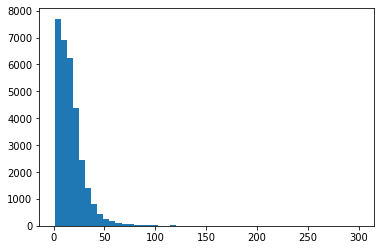

In [26]:
# распреление длины слов в предложении
plt.hist([len(s.split(' ')) for s in all_sents], bins=50)

In [27]:
MAX_LEN = 30

In [28]:
X = torch.zeros((len(all_sents), MAX_LEN), dtype=int)
# готовим матрицу - строка - предложение, столбец - индекс слова в этой позиции
for i in tqdm(range(len(all_sents))):
    for j, w in enumerate(all_sents[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])
        
X = X.to(dev)

100%|██████████| 31148/31148 [00:04<00:00, 6567.97it/s]


In [29]:
X[0:1]

tensor([[12742,  7228, 38083,  7138, 44192, 23090, 16587, 44510, 11099,  7111,
           178,  4016, 36587, 38083,  4883, 34556, 15473, 32486,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')

In [30]:
X.shape

torch.Size([31148, 30])

In [31]:
a = [1,2,3]
[i*2 for i in a]

[2, 4, 6]

In [32]:
BATCH_SIZE = 100

In [33]:
class Network(torch.nn.Module):

    def __init__(self, dev, model_w2v_weights):
        super(Network, self).__init__()
        self.dev = dev
        self.word_embeddings = torch.nn.Embedding.from_pretrained(model_w2v_weights).to(self.dev)
        self.gru = torch.nn.LSTM(EMBED_SIZE, 128, num_layers = 2, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)
        
    def get_embeddings(self,sentences):
        csentences = sentences.size()[0]
        cwords = sentences.size()[1]
        embeds = torch.zeros(csentences, cwords, EMBED_SIZE).to(self.dev)
        for i in range(csentences):  
            for k in range(cwords):
                if sentences[i][k] == 0:
                    embeds[i][k] = self.word_embeddings[0]
                    break
                embeds[i][k] = torch.FloatTensor ([ emb for emb in self.word_embeddings[ sentences[i][k] ] ])
        return embeds

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state
    
    def forward_state(self, sentences, state):
        #embeds = self.get_embeddings(sentences)
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [34]:
model = Network(dev, model_w2v_weights)
model.forward(X[0:1])[0].shape

torch.Size([1, 30, 44946])

In [35]:
def generate_sentence(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    for i in range(MAX_LEN):
        #X = torch.Tensor([[WORD_TO_INDEX[sentence[i]]]]).type(torch.long)
        X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        #get(w, WORD_TO_INDEX['<miss>']
        X = X.to(dev)
        if i == 0:
            result, state = model.forward(X)
        else:
            result, state = model.forward_state(X, state)
        prediction = result[0, -1, :]
        index_of_prediction = prediction.argmax()
        if i >= len(sentence) - 1:
            if index_of_prediction == 0:
                break
        sentence.append(INDEX_TO_WORD[index_of_prediction])
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [36]:
generate_sentence('проект направлена на')

проект направлена на крупнейших предприятия6 глава глава предприятия6 предприятия6 глава предприятия6 предприятия6 предприятия6 предприятия6 предприятия6 вакансию вакансию вакансию предприятия6 предприятия6 предприятия6 предприятия6 отмечаться отмечаться вакансию предприятия6 предприятия6 предприятия6 предприятия6 отмечаться отмечаться вакансию предприятия6


In [37]:
lrate = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
#optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

In [39]:
count = 0

for ep in range(2000):
    
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
    
    count += 1
    if count == 1:
        count = 0
        trloss = train_loss / train_passed
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, end - start, trloss))
        #generate_sentence('проект позволяет')

Epoch 0. Time: 49.826, Train loss: 12.090
Epoch 1. Time: 48.625, Train loss: 12.647


KeyboardInterrupt: 

In [45]:
generate_sentence('предлагается')

предлагается создать систему платформу для воспитанников детских домов в возрасте от 14 до 18 лет


In [46]:
generate_sentence('проект позволяет')

проект позволяет направлен развить на в территории котором городе слушатели с на ограниченными муниципальном возможностями и детей в от условиях форме <pad> образования <pad> и <pad> о <pad> <pad> <pad> <pad> <pad>


In [47]:
generate_sentence('в нашей стране дети')

в нашей стране дети рамках стране существует смогут жертвами на в не в плечи городах более целом дети и 30 человек <pad> не 40 <pad> <pad> 0 <pad> <pad> <pad> класс <pad> <pad> <pad>


In [48]:
generate_sentence('низкий уровень образования')

низкий уровень образования уровень финансовой и грамотности грамотности их <pad> <pad> на <pad> <pad> первом <pad> <pad> знаний <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [49]:
generate_sentence('преподаватели будут')

преподаватели будут могут проводиться проводиться на в базе <pad> учебных <pad> заведениях <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [155]:
descrs[105]


'преподаватели омского государственного университета под руководством константина шестакова совместно о студентами волонтерами выезжают в детские дома города и области и проводят коммуникативные тренинги готовят вместе играют в настольные и спортивные игры.общение отличается от приездов волонтеров из других организаций тем что наши волонтеры приезжают в каждый детский дом регулярно раз в месяц знают детей лично и отслеживают их жизненные ситуации.поэтому была выявлена ситуация когда многие воспитанники детских домой не могут набрать высокий бал егэ открывающих для них возможность получить высшее образование на бюджетной основе.бесплатная учеба единственный шанс для этих детей получить высшее образование.поэтому появилась идея привлечь на безвозмездной основе лучших преподавателей не только из омска и студентов в том числе иностранных для подготовке по английскому для подготовке к егэ детей из детских домой как в режиме он лайн на специально разработанной интернет платформе так в обычно

In [145]:
# torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, "model_allw_w2v_rnn2l-300-128.pt")

In [117]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load("model_allw_rnn2l-400-256.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

model.eval()

Network(
  (word_embeddings): Embedding(20002, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True)
  (hidden2tag): Linear(in_features=256, out_features=20002, bias=True)
)

In [118]:
model.train()

Network(
  (word_embeddings): Embedding(20002, 400)
  (gru): GRU(400, 256, num_layers=2, batch_first=True)
  (hidden2tag): Linear(in_features=256, out_features=20002, bias=True)
)

In [164]:
c['преподаватели']

84

In [44]:
c['будет']

1283

In [48]:
c.most_common(500)

[('и', 21757),
 ('в', 18684),
 ('на', 7540),
 ('с', 6533),
 ('для', 5371),
 ('по', 4117),
 ('не', 3524),
 ('проекта', 3413),
 ('к', 3142),
 ('как', 2422),
 ('что', 2298),
 ('а', 2041),
 ('детей', 1997),
 ('из', 1893),
 ('о', 1651),
 ('проект', 1626),
 ('это', 1586),
 ('их', 1507),
 ('или', 1477),
 ('от', 1449),
 ('1', 1315),
 ('–', 1285),
 ('будет', 1283),
 ('у', 1203),
 ('образования', 1184),
 ('при', 1184),
 ('2', 1170),
 ('которые', 1116),
 ('за', 1075),
 ('также', 1052),
 ('3', 1010),
 ('развития', 987),
 ('но', 983),
 ('работы', 973),
 ('так', 973),
 ('обучения', 933),
 ('реализации', 926),
 ('жизни', 909),
 ('будут', 877),
 ('россии', 787),
 ('профессии', 767),
 ('может', 764),
 ('создание', 763),
 ('области', 763),
 ('людей', 759),
 ('деятельности', 758),
 ('быть', 735),
 ('только', 709),
 ('т', 708),
 ('то', 705),
 ('рамках', 705),
 ('до', 705),
 ('можно', 704),
 ('школьников', 701),
 ('более', 693),
 ('время', 686),
 ('проведение', 679),
 ('все', 676),
 ('4', 669),
 ('они', 66

In [162]:
# save descrs to disk
import pandas as pd
df = pd.DataFrame(descrs)
df.to_csv("descrs.csv", encoding = 'utf8')


### Пробуем эмбеддинги word2vec


ModuleNotFoundError: No module named 'gensim'